In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### [Air Quality Data Set](https://archive.ics.uci.edu/ml/datasets/Air+Quality)
#### Data Set Information:

The dataset contains 9358 instances of hourly averaged responses from an array of 5 metal oxide chemical sensors embedded in an Air Quality Chemical Multisensor Device. The device was located on the field in a significantly polluted area, at road level,within an Italian city. Data were recorded from March 2004 to February 2005 (one year)representing the longest freely available recordings of on field deployed air quality chemical sensor devices responses. Ground Truth hourly averaged concentrations for CO, Non Metanic Hydrocarbons, Benzene, Total Nitrogen Oxides (NOx) and Nitrogen Dioxide (NO2) and were provided by a co-located reference certified analyzer. Evidences of cross-sensitivities as well as both concept and sensor drifts are present as described in De Vito et al., Sens. And Act. B, Vol. 129,2,2008 (citation required) eventually affecting sensors concentration estimation capabilities. Missing values are tagged with -200 value.
This dataset can be used exclusively for research purposes. Commercial purposes are fully excluded.

#### Data Set description:

- 0 Date (DD/MM/YYYY)
- 1 Time (HH.MM.SS)
- 2 True hourly averaged concentration CO in mg/m^3 (reference analyzer)
- 3 PT08.S1 (tin oxide) hourly averaged sensor response (nominally CO targeted)
- 4 True hourly averaged overall Non Metanic HydroCarbons concentration in microg/m^3 (reference analyzer)
- 5 True hourly averaged Benzene concentration in microg/m^3 (reference analyzer)
- 6 PT08.S2 (titania) hourly averaged sensor response (nominally NMHC targeted)
- 7 True hourly averaged NOx concentration in ppb (reference analyzer)
- 8 PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally NOx targeted)
- 9 True hourly averaged NO2 concentration in microg/m^3 (reference analyzer)
- 10 PT08.S4 (tungsten oxide) hourly averaged sensor response (nominally NO2 targeted)
- 11 PT08.S5 (indium oxide) hourly averaged sensor response (nominally O3 targeted)
- 12 Temperature in Â°C
- 13 Relative Humidity (%)
- 14 AH Absolute Humidity

#### Analysis

The variable to be worked on is the PT08.S1(CO)  

### Dataset overview

In [2]:
# Load the data set
df = pd.read_excel('data/AirQualityUCI.xlsx')
df

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.600,48.875001,0.757754
1,2004-03-10,19:00:00,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.300,47.700000,0.725487
2,2004-03-10,20:00:00,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.900,53.975000,0.750239
3,2004-03-10,21:00:00,2.2,1375.50,80,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.000,60.000000,0.786713
4,2004-03-10,22:00:00,1.6,1272.25,51,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.150,59.575001,0.788794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,2005-04-04,10:00:00,3.1,1314.25,-200,13.529605,1101.25,471.7,538.50,189.8,1374.25,1728.50,21.850,29.250000,0.756824
9353,2005-04-04,11:00:00,2.4,1162.50,-200,11.355157,1027.00,353.3,603.75,179.2,1263.50,1269.00,24.325,23.725000,0.711864
9354,2005-04-04,12:00:00,2.4,1142.00,-200,12.374538,1062.50,293.0,603.25,174.7,1240.75,1092.00,26.900,18.350000,0.640649
9355,2005-04-04,13:00:00,2.1,1002.50,-200,9.547187,960.50,234.5,701.50,155.7,1041.00,769.75,28.325,13.550000,0.513866


In [3]:
# Display the types of each column
df.dtypes

Date             datetime64[ns]
Time                     object
CO(GT)                  float64
PT08.S1(CO)             float64
NMHC(GT)                  int64
C6H6(GT)                float64
PT08.S2(NMHC)           float64
NOx(GT)                 float64
PT08.S3(NOx)            float64
NO2(GT)                 float64
PT08.S4(NO2)            float64
PT08.S5(O3)             float64
T                       float64
RH                      float64
AH                      float64
dtype: object

In [4]:
# Summary statistics of each column
df.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000
mean,-34.207524,1048.869652,-159.090093,1.865576,894.475963,168.604200,794.872333,58.135898,1391.363266,974.951534,9.776600,39.483611,-6.837604
std,77.657170,329.817015,139.789093,41.380154,342.315902,257.424561,321.977031,126.931428,467.192382,456.922728,43.203438,51.215645,38.976670
min,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000
25%,0.600000,921.000000,-200.000000,4.004958,711.000000,50.000000,637.000000,53.000000,1184.750000,699.750000,10.950000,34.050000,0.692275
50%,1.500000,1052.500000,-200.000000,7.886653,894.500000,141.000000,794.250000,96.000000,1445.500000,942.000000,17.200000,48.550000,0.976823
75%,2.600000,1221.250000,-200.000000,13.636091,1104.750000,284.200000,960.250000,133.000000,1662.000000,1255.250000,24.075000,61.875000,1.296223
max,11.900000,2039.750000,1189.000000,63.741476,2214.000000,1479.000000,2682.750000,339.700000,2775.000000,2522.750000,44.600000,88.725000,2.231036


By the description of the dataset it's clear how the missing values (tagged with `-200.000` value) are affecting the overall dataset as it's the min for all variables.

### Cleaning missing data

In [5]:
# replace all -200 with NaN
df.replace(-200, np.NaN, inplace=True)

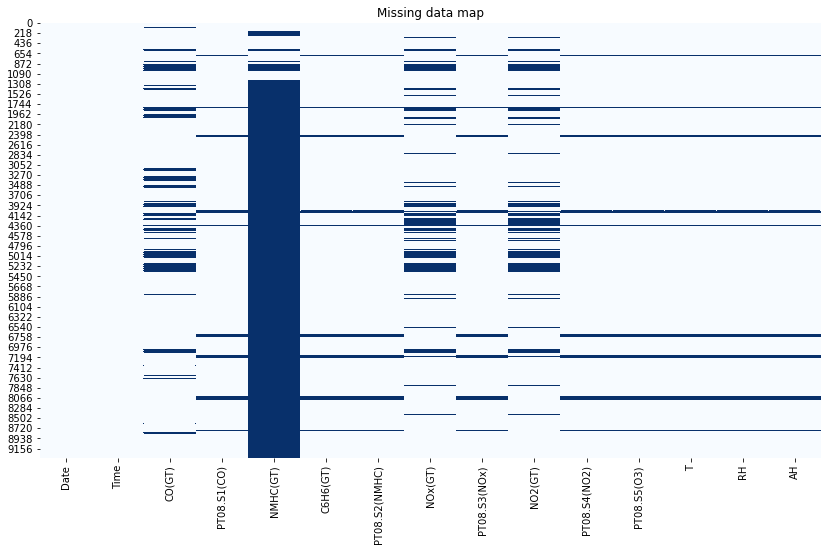

In [6]:
plt.figure(figsize=(14,8))
sns.heatmap(df.isna(), cbar=False, cmap="Blues").set_title("Missing data map")
plt.show()

In [7]:
# Percentage of missing values per column
nan_perc = df.isna().sum()/len(df.index)*100
nan_perc

Date              0.000000
Time              0.000000
CO(GT)           17.986534
PT08.S1(CO)       3.911510
NMHC(GT)         90.231912
C6H6(GT)          3.911510
PT08.S2(NMHC)     3.911510
NOx(GT)          17.516298
PT08.S3(NOx)      3.911510
NO2(GT)          17.548360
PT08.S4(NO2)      3.911510
PT08.S5(O3)       3.911510
T                 3.911510
RH                3.911510
AH                3.911510
dtype: float64

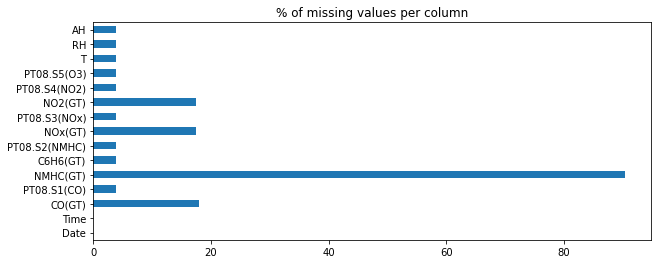

In [8]:
plt.figure(figsize=(10,4))
nan_perc.plot.barh().set_title('% of missing values per column')
plt.show()

* The concentration of missing values on variable **NMHC(GT)** is considerably high (over `90%`).
* Columns **NOx(GT)** and **NO2(GT)** seems correlatated regarding missing data.
* The columns **PT08.S1(CO)**, **C6H6(GT)**, **PT08.S2(NMHC)**, **PT08.S3(NOx)**, **PT08.S4(NO2)**, **PT08.S5(O3)**, **T**, **RH**, **AH**, are also higly correlated on their missing data patterns.   
<br><br>
Due to the high concentration of missing values in **NMHC(GT)** it makes sense to drop this column. <br>
Three other columns also display a high concentration of missing values **CO(GT), NOx(GT), NO2(GT)** of over `17%` and these missing values will be filled with the last valid observation.


In [9]:
# Drop column which is full of missing values
df.drop(columns=['NMHC(GT)'], inplace=True)
df.head()

,Date,Time,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360.00,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,0.757754
1,2004-03-10,19:00:00,2.0,1292.25,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,0.725487
2,2004-03-10,20:00:00,2.2,1402.00,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,0.750239
3,2004-03-10,21:00:00,2.2,1375.50,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,0.786713
4,2004-03-10,22:00:00,1.6,1272.25,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,0.788794


In [10]:
# Fill missing values of all other columns
df.fillna(method='ffill', inplace=True)

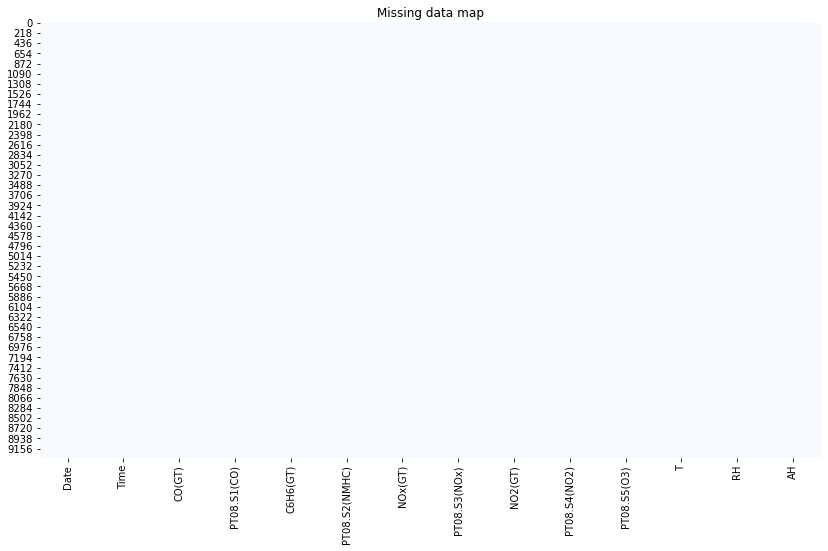

In [11]:
plt.figure(figsize=(14,8))
sns.heatmap(df.isna(), cbar=False, cmap="Blues").set_title("Missing data map")
plt.show()

All missing values were gone!

### Dealing with outliers

[]

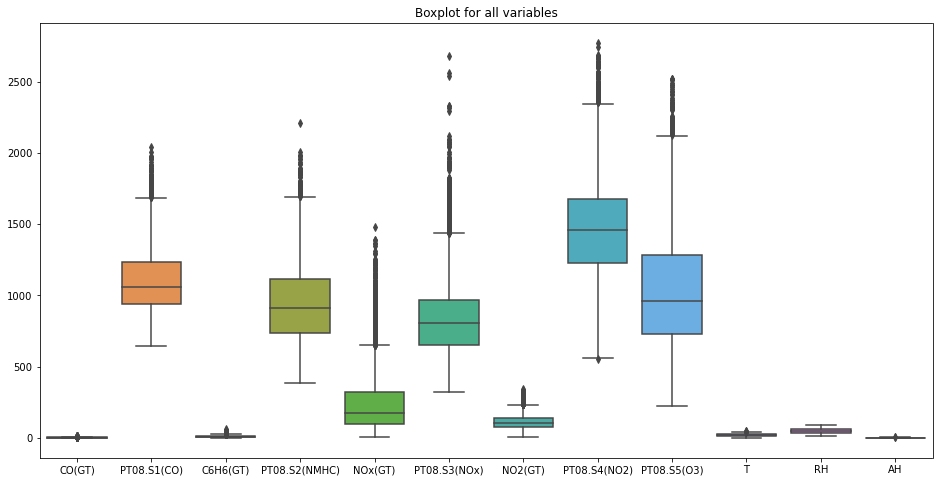

In [12]:
# showing the boxplot for all variables (except Date and Time)
plt.figure(figsize=(16,8))
sns.boxplot(data=df.loc[:, 'CO(GT)':'AH']).set_title("Boxplot for all variables")
plt.plot()

By the boxplot it's clear there're some outliers.<br>
Q1 and Q3 are the lower and upper quartiles respectively.<br>

Considering the [inner fences](https://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm) to detect outliers:<br>
lower inner fence: Q1 - 1.5*IQ<br>
upper inner fence: Q3 + 1.5*IQ

In [13]:
# go through all the columns (starting from column CO(GT)),
# calculate the outlier's fences and mark as null each value that
# goes beyond these limitations.

for col in df.columns[2:]:
    q1 = df[col].quantile(.25)
    q3 = df[col].quantile(.75)
    
    lower_f = q1 - 1.5*q1
    upper_f = q3 + 1.5*q3
    
    df[col] = df[col].apply(lambda x: np.nan if ((x<lower_f) or (x>upper_f)) else x)

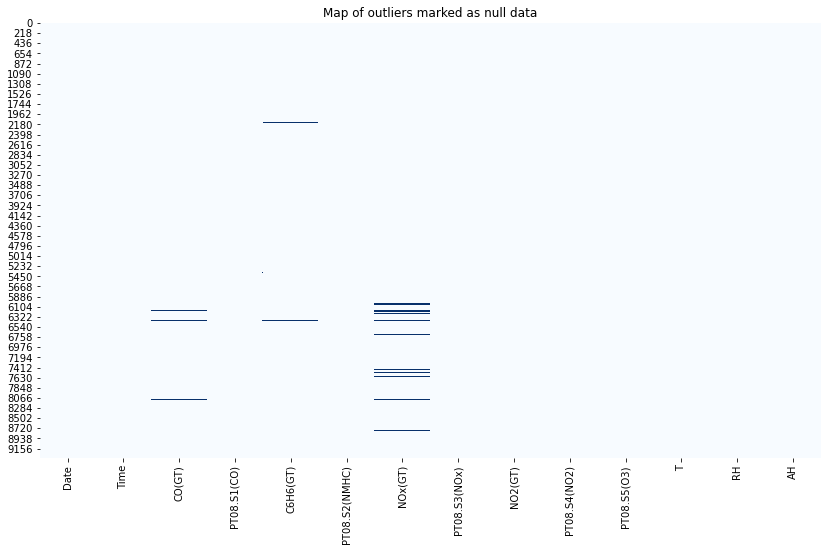

In [14]:
# plot the new map of outliers (marked as null data)
plt.figure(figsize=(14,8))
sns.heatmap(df.isna(), cbar=False, cmap="Blues").set_title("Map of outliers marked as null data")
plt.show()

In [15]:
# Percentage of missing values per column
nan_perc = df.isna().sum()/len(df.index)*100
nan_perc

Date             0.000000
Time             0.000000
CO(GT)           0.705354
PT08.S1(CO)      0.000000
C6H6(GT)         0.897724
PT08.S2(NMHC)    0.000000
NOx(GT)          2.532863
PT08.S3(NOx)     0.032062
NO2(GT)          0.000000
PT08.S4(NO2)     0.000000
PT08.S5(O3)      0.000000
T                0.000000
RH               0.000000
AH               0.000000
dtype: float64

For these outliers the choice will be the same regarding missing values, propagate the last valid observation forward.

In [16]:
# Fill outliers with last valid observation
df.fillna(method='ffill', inplace=True)

### Visualizing the CO concentration patterns regarding time.

In [17]:
# Create a column with the day of the week names for each date
df['DayofWeek'] = df['Date'].dt.day_name()
df.head()

,Date,Time,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,DayofWeek
0,2004-03-10,18:00:00,2.6,1360.00,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,0.757754,Wednesday
1,2004-03-10,19:00:00,2.0,1292.25,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,0.725487,Wednesday
2,2004-03-10,20:00:00,2.2,1402.00,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,0.750239,Wednesday
3,2004-03-10,21:00:00,2.2,1375.50,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,0.786713,Wednesday
4,2004-03-10,22:00:00,1.6,1272.25,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,0.788794,Wednesday


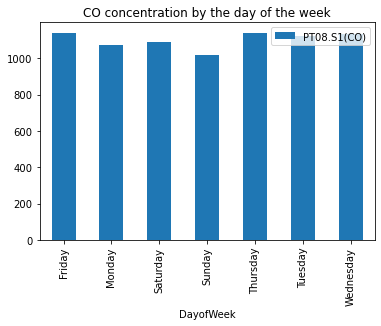

In [18]:
# Print the mean of CO concentration by the day of the week
weekday_grp = df.groupby(['DayofWeek'])
weekday_grp[['Time','PT08.S1(CO)']].mean().plot.bar().set_title('CO concentration by the day of the week')
plt.show()

The concentration of CO on Sunday is reduced compared to the other days of the week as can be seen in the barplot above.<br>
It'll be interesting to see a sequence of the plots for the mean concentration on each day. 

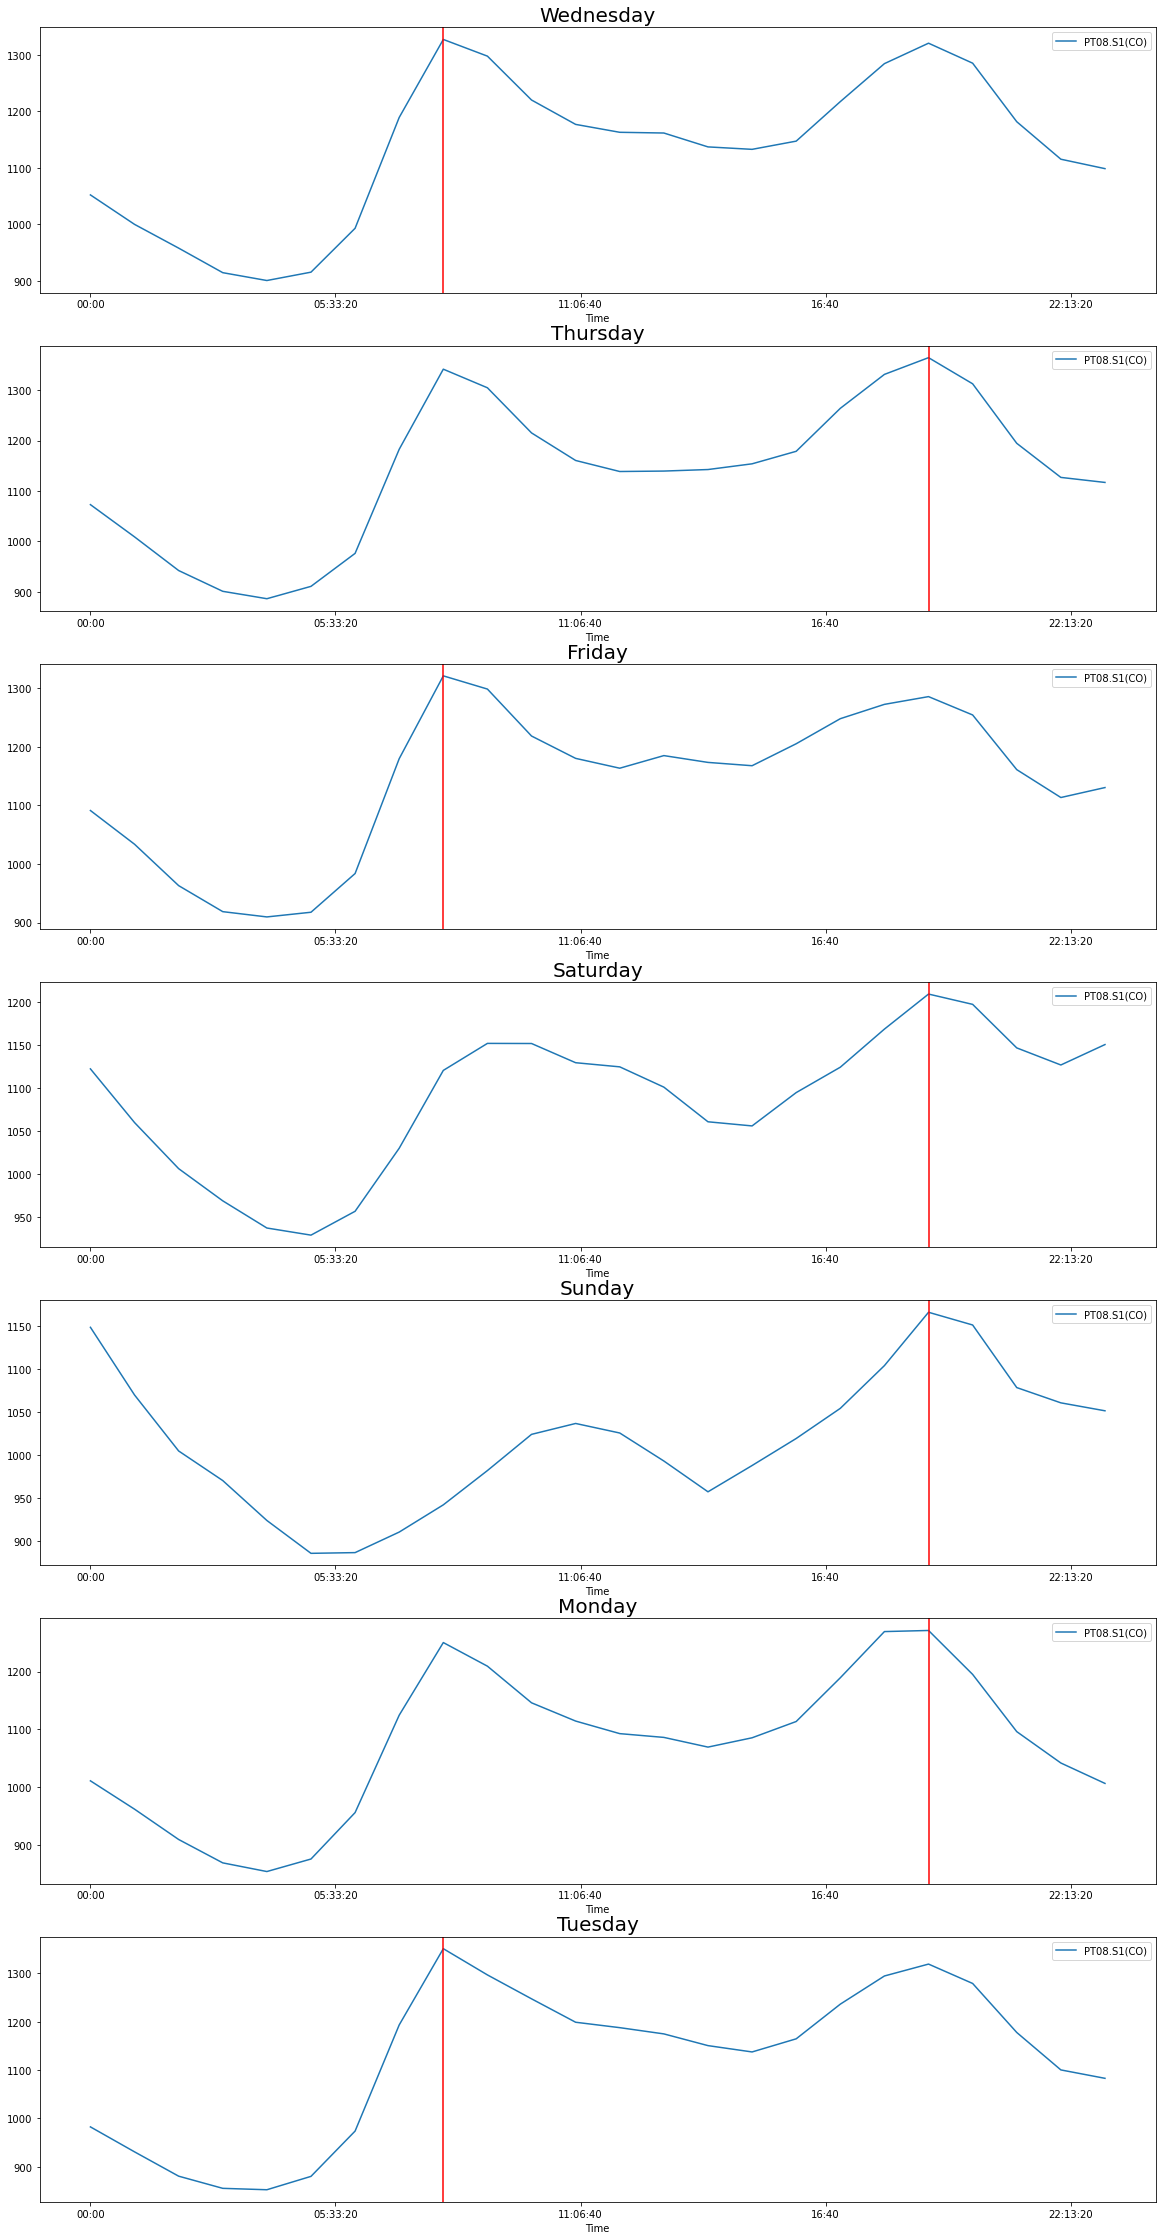

In [19]:
# Plot the mean of CO concentration per weekday
fig, axes = plt.subplots(7, 1, figsize=(20,40))

i=0
for wday in df['DayofWeek'].unique():
    tmp_grp = weekday_grp[['Time','PT08.S1(CO)']].get_group(wday)
    daymean = tmp_grp.groupby('Time')
    daymean.mean().plot(ax=axes[i]).set_title(wday, fontsize=20)
    axes[i].axvline(x=daymean.mean().idxmax()[0], color='red')
    i += 1

On the plots above each day is marked by a vertical red line in its maximum value.<br> 
It's noticeable that everyday has two peaks, one in the morning and the other by the end of afternoon. These correspond with the rush time.<br> 
The graphs for Saturday and Sunday show smaller peaks, especially in the Sunday morning. 

It's also interesting to see how's the concentration of CO along the months.

In [20]:
# Separate data by year-month
df['Month'] = df['Date'].dt.to_period('M')
df.head()

,Date,Time,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,DayofWeek,Month
0,2004-03-10,18:00:00,2.6,1360.00,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,0.757754,Wednesday,2004-03
1,2004-03-10,19:00:00,2.0,1292.25,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,0.725487,Wednesday,2004-03
2,2004-03-10,20:00:00,2.2,1402.00,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,0.750239,Wednesday,2004-03
3,2004-03-10,21:00:00,2.2,1375.50,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,0.786713,Wednesday,2004-03
4,2004-03-10,22:00:00,1.6,1272.25,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,0.788794,Wednesday,2004-03


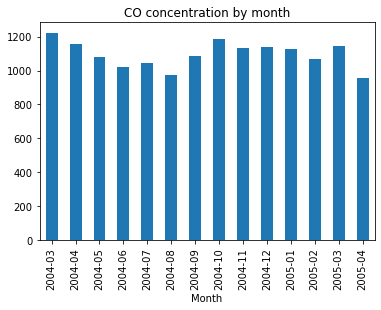

In [21]:
# Print the mean of CO concentration by the month
month_grp = df.groupby(['Month'])
month_grp['PT08.S1(CO)'].mean().plot.bar(sort_columns=True).set_title('CO concentration by month')
plt.show()

A lower concentration of CO is observed on the months June, July and August. These months correspond to the summer holidays.
This is when most people travel and the city becomes less crowded.
<br>
One curious case is April of 2005 which has the lowest CO concentration. It's important to see the plot of the number of samples for each month, as this is the last month of the dataset the samples weren't collected during the whole period.

[]

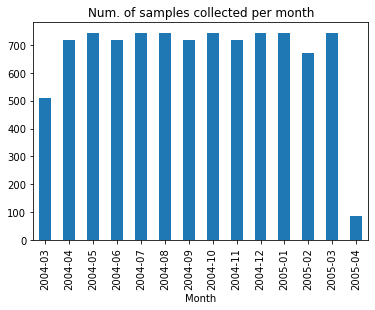

In [22]:
month_grp['PT08.S1(CO)'].count().plot.bar().set_title('Num. of samples collected per month')
plt.plot()

With the plot above it's clear why the concentration of CO in April 2005 was that low, few samples were collected.
<br>
On the other hand it's also interesting that in March 2004 a smaller amount of samples were collecte, comparing to the other months of the same year and it's still he month with the highest concentration of CO. 

### Correlation between variables

In [23]:
# Correlation table for all variables
df.corr()

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
CO(GT),1.000000,0.759064,0.771312,0.765477,0.772900,-0.627463,0.699228,0.507120,0.735375,0.004444,0.037156,0.021588
PT08.S1(CO),0.759064,1.000000,0.886335,0.896033,0.631795,-0.779132,0.581036,0.676419,0.901469,0.037062,0.120017,0.121736
C6H6(GT),0.771312,0.886335,1.000000,0.981263,0.616722,-0.750577,0.543773,0.754590,0.864274,0.200872,-0.064942,0.157680
PT08.S2(NMHC),0.765477,0.896033,0.981263,1.000000,0.617881,-0.799429,0.566615,0.769774,0.876614,0.231034,-0.082055,0.174906
NOx(GT),0.772900,0.631795,0.616722,0.617881,1.000000,-0.626949,0.767380,0.177231,0.701216,-0.243472,0.181990,-0.141152
PT08.S3(NOx),-0.627463,-0.779132,-0.750577,-0.799429,-0.626949,1.000000,-0.593315,-0.535851,-0.797303,-0.132938,-0.060393,-0.216775
NO2(GT),0.699228,0.581036,0.543773,0.566615,0.767380,-0.593315,1.000000,0.107364,0.633692,-0.194383,-0.098735,-0.338711
PT08.S4(NO2),0.507120,0.676419,0.754590,0.769774,0.177231,-0.535851,0.107364,1.000000,0.579183,0.558430,-0.015138,0.630271
PT08.S5(O3),0.735375,0.901469,0.864274,0.876614,0.701216,-0.797303,0.633692,0.579183,1.000000,-0.044840,0.137780,0.055469
T,0.004444,0.037062,0.200872,0.231034,-0.243472,-0.132938,-0.194383,0.558430,-0.044840,1.000000,-0.570698,0.654827


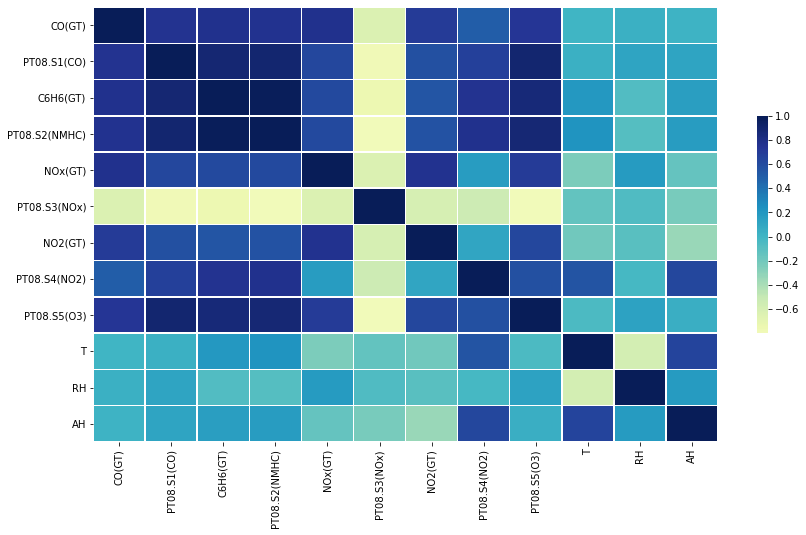

In [24]:
# heatmap
plt.figure(figsize=(14,8))
sns.heatmap(df.corr(), cmap="YlGnBu", center=0, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

The variable that has the highest level of correlation with **PT08.S1(CO)** is **PT08.S5(O3)**. <br>
It's also higly correlated with **PT08.S2(NMHC)** and **C6H6(GT)**.<br> 
Below the correlation list of **PT08.S5(O3)** regarding other variables and its scatterplot with **PT08.S5(O3)**.

In [25]:
df.corr()['PT08.S1(CO)'].sort_values(ascending=False)

PT08.S1(CO)      1.000000
PT08.S5(O3)      0.901469
PT08.S2(NMHC)    0.896033
C6H6(GT)         0.886335
CO(GT)           0.759064
PT08.S4(NO2)     0.676419
NOx(GT)          0.631795
NO2(GT)          0.581036
AH               0.121736
RH               0.120017
T                0.037062
PT08.S3(NOx)    -0.779132
Name: PT08.S1(CO), dtype: float64

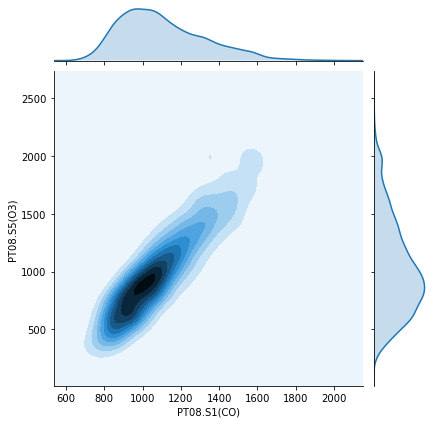

In [26]:
# scatterplot
sns.jointplot(x="PT08.S1(CO)", y="PT08.S5(O3)", kind='kde', data=df)
plt.show()

The variables that showed the best correlation levels are selected for the model.<br>
Furthermore, a pairplot of these variables is plotted bellow.

In [27]:
# selection of the variables to be used in the prediction
df_model = df[['CO(GT)','C6H6(GT)','PT08.S2(NMHC)','NOx(GT)','PT08.S3(NOx)','NO2(GT)','PT08.S4(NO2)','PT08.S5(O3)']]

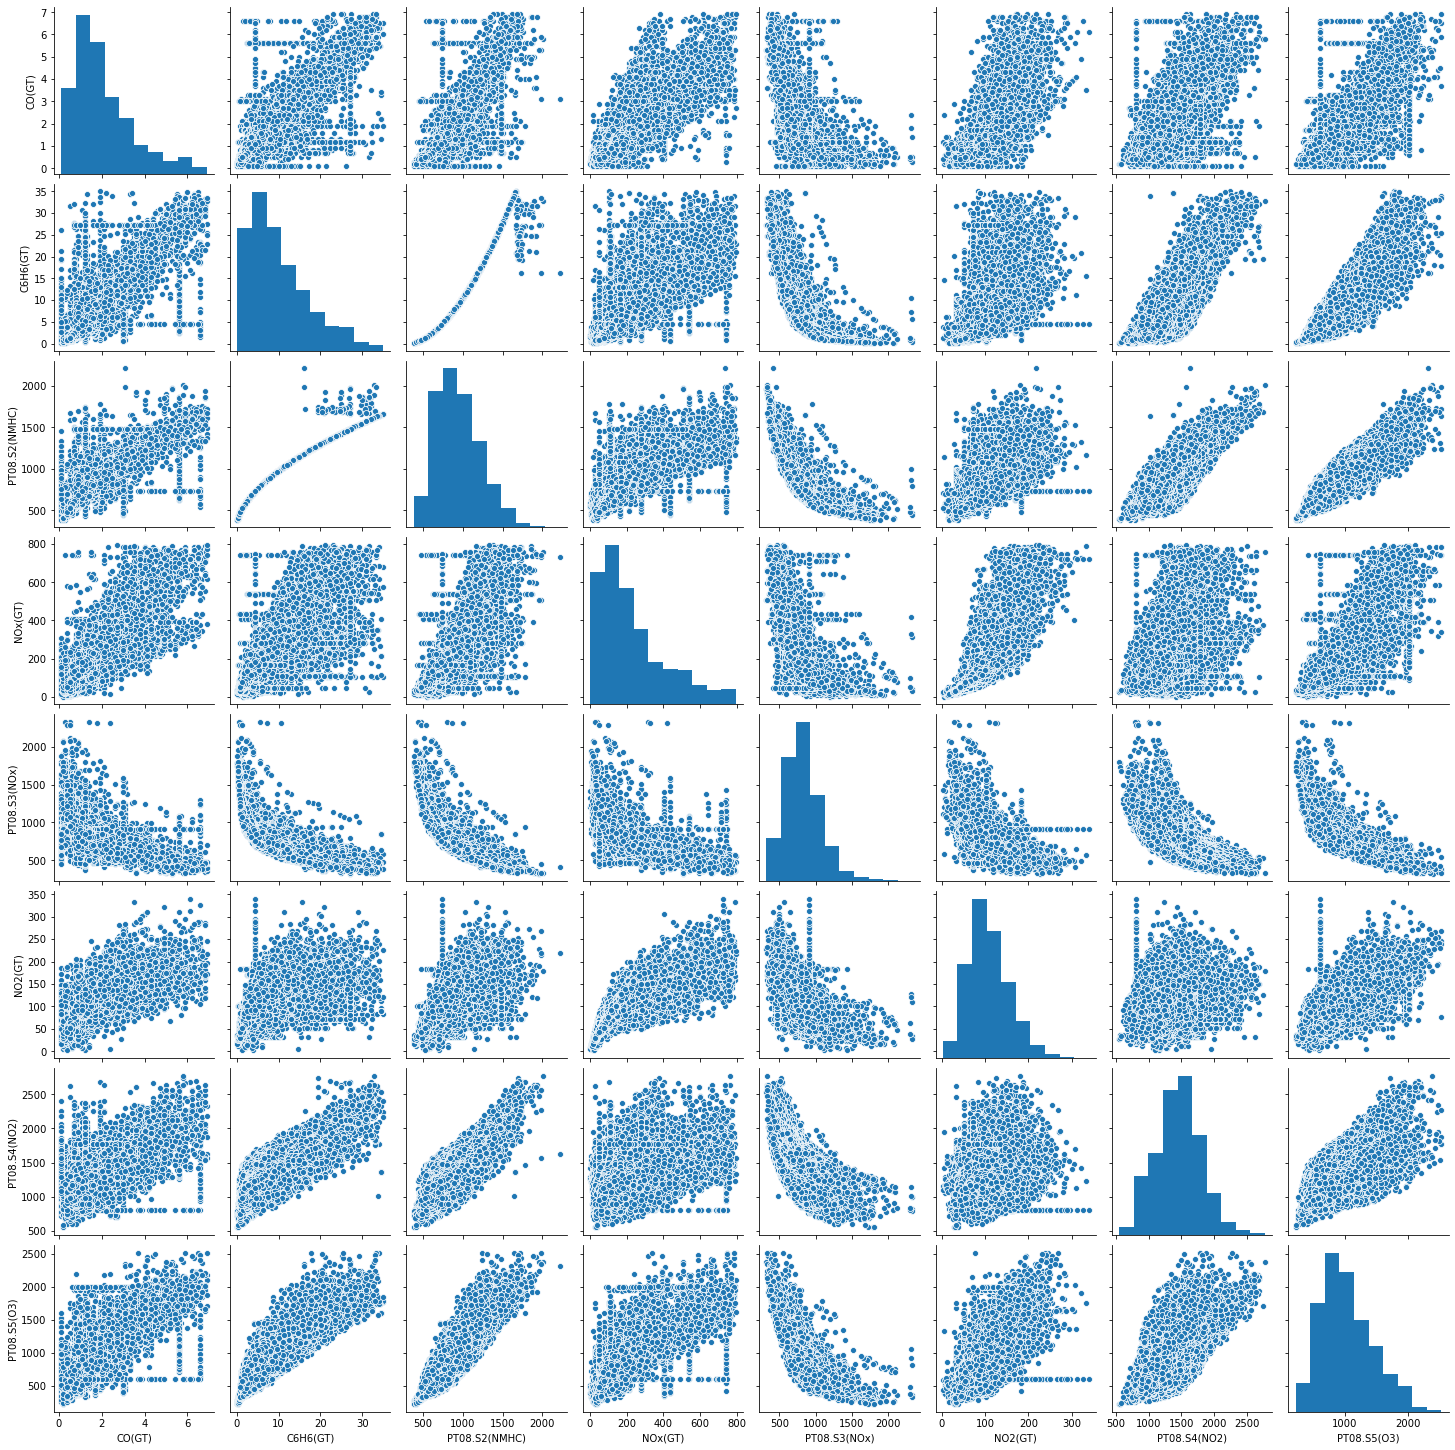

In [28]:
# pairplot of the selected variables
sns.pairplot(data=df_model)

### Prediction model

For the prediction model were selected the variables with more correlation to the CO concentration **PT08.S1(CO)**.

In [29]:
# selection of the variables to be used in the prediction
df_model = df[['CO(GT)','C6H6(GT)','PT08.S2(NMHC)','NOx(GT)','PT08.S3(NOx)','NO2(GT)','PT08.S4(NO2)','PT08.S5(O3)']]

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
X = df_model

# target variable
y = df['PT08.S1(CO)']

# devide train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [32]:
# Ordinary Least Squares analysis
# https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html
import statsmodels.api as sm

X_sm = sm.add_constant(X)
model = sm.OLS(y,X_sm)
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            PT08.S1(CO)   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     7992.
Date:                Sat, 15 Aug 2020   Prob (F-statistic):               0.00
Time:                        12:53:29   Log-Likelihood:                -54094.
No. Observations:                9357   AIC:                         1.082e+05
Df Residuals:                    9348   BIC:                         1.083e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           649.1231     15.394     42.166      0.000     618.947     679.299
CO(GT)           19.9536      1.252     15.934      0.000      17.499      22.408
C6H6(GT)          5.2187      0.639      8.172      0.000       3.967       6.470
PT08.S2(NMHC)     0.0487      0.020      2.447      0.014       0.010       0.088
NOx(GT)          -0.0584      0.009     -6.163      0.000      -0.077      -0.040
PT08.S3(NOx)     -0.0731      0.006    -11.932      0.000      -0.085      -0.061
NO2(GT)           0.1355      0.032      4.177      0.000       0.072       0.199
PT08.S4(NO2)      0.0715      0.005     13.466      0.000       0.061       0.082
PT08.S5(O3)       0.2617      0.005     55.405      0.000       0.252       0.271
==============================================================================
Omnibus:                      260.778   Durbin-Watson:                   0.173
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              375.610
Skew:                           0.298   Prob(JB):                     2.74e-82
Kurtosis:                       3.779   Cond. No.                     4.25e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.25e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

`F-statistic` has a large value of `7992` suggesting that at least one of the variables must be related to our prediction target variable of CO concentration.  
<br>
As the `p-values` of all variables are smaller than `0.05`, they are all considered statistically significant. It means that there's a strong evidence that for each one of them there's a real association with the concentration of CO **PT08.S1(CO)**. 
<br>
R-squared looks good, it shows that this model explains `87.2%` of the variation in the CO concentration.<br><br>

Trying some different prediction models to see the results.

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

# Linear regression
lreg = LinearRegression()
lreg.fit(X_train, y_train)

print("Linear Regression")
print("-----------------")
print("R2 score (train set): {:.4f}".format(lreg.score(X_train, y_train)))
print("R2 score (test set): {:.4f}".format(lreg.score(X_test, y_test)))

# 10-fold cross validation
lreg_cv = np.mean(cross_val_score(lreg, X_train, y_train, cv=10))
print("Mean cross validation 10-fold accuracy: {:.4f}".format(lreg_cv))

# mean squared error
y_pred_lreg = lreg.predict(X_test)
mse = mean_squared_error(y_test, y_pred_lreg)
print("MSE: {:.4f}".format(mse))
print("RMSE: {:.4f}".format(np.sqrt(mse)))

Linear Regression
-----------------
R2 score (train set): 0.8718
R2 score (test set): 0.8735
Mean cross validation 10-fold accuracy: 0.8709
MSE: 6259.5948
RMSE: 79.1176


In [34]:
from sklearn.ensemble import RandomForestRegressor

# Random Forest
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

print("Random Forest Regressor")
print("-----------------------")
print("R2 score accuracy (train set): {:.4f}".format(rf.score(X_train, y_train)))
print("R2 score accuracy (test set): {:.4f}".format(rf.score(X_test, y_test)))

# 10-fold cross validation
rf_cv = np.mean(cross_val_score(rf, X_train, y_train, cv=10))
print("Mean cross validation 10-fold accuracy: {:.4f}".format(rf_cv))

# mean squared error
y_pred_rf = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred_rf)
print("MSE: {:.4f}".format(mse))
print("RMSE: {:.4f}".format(np.sqrt(mse)))

Random Forest Regressor
-----------------------
R2 score accuracy (train set): 0.9913
R2 score accuracy (test set): 0.9385
Mean cross validation 10-fold accuracy: 0.9362
MSE: 3041.9539
RMSE: 55.1539


In [35]:
import xgboost as xgb


#XGBoost Regressor
xgbr = xgb.XGBRegressor(verbosity=0) 
xgbr.fit(X_train, y_train)


print("XGBoost Regressor")
print("-----------------")
print("R2 score (train set): {:.4f}".format(xgbr.score(X_train, y_train)))
print("R2 score (test set): {:.4f}".format(xgbr.score(X_test, y_test)))

# 10-fold cross validation
xgbr_cv = np.mean(cross_val_score(xgbr, X_train, y_train, cv=10))
print("Mean cross validation 10-fold accuracy: {:.4f}".format(xgbr_cv))

# mean squared error
y_pred_xgbr = xgbr.predict(X_test)
mse = mean_squared_error(y_test, y_pred_xgbr)
print("MSE: {:.4f}".format(mse))
print("RMSE: {:.4f}".format(np.sqrt(mse)))

XGBoost Regressor
-----------------
R2 score (train set): 0.9865
R2 score (test set): 0.9331
Mean cross validation 10-fold accuracy: 0.9335
MSE: 3308.5900
RMSE: 57.5203


The train dataset was trained using 3 different algorithms, Linear Regression, Random Forest Regressor and XGBoost, which are higly interpretable.<br>

After each model training, an accuracy R-squared was performed on the training and test datasets. It was also performed a 10-fold cross validation in the training dataset using each model. These two processes seems to provide good enough metrics for the prediction of the averaged concentration of CO. <br>


Random Forest showed better accuracy results when compared to the Linear Regression and XGBoost (which performed almost as good as) models. The difference is considerably more significant compared to Linear Regression. Furthermore a metric of MSE (Mean Squared Error) and RMSE (Root Mean Squared Error) was also applied and confirmed the result.<br>

For the sake of making it a bit more visual, below follows a plot of a set of points from the original test dataset and the predicted using Random Forest (the best model for this dataset).

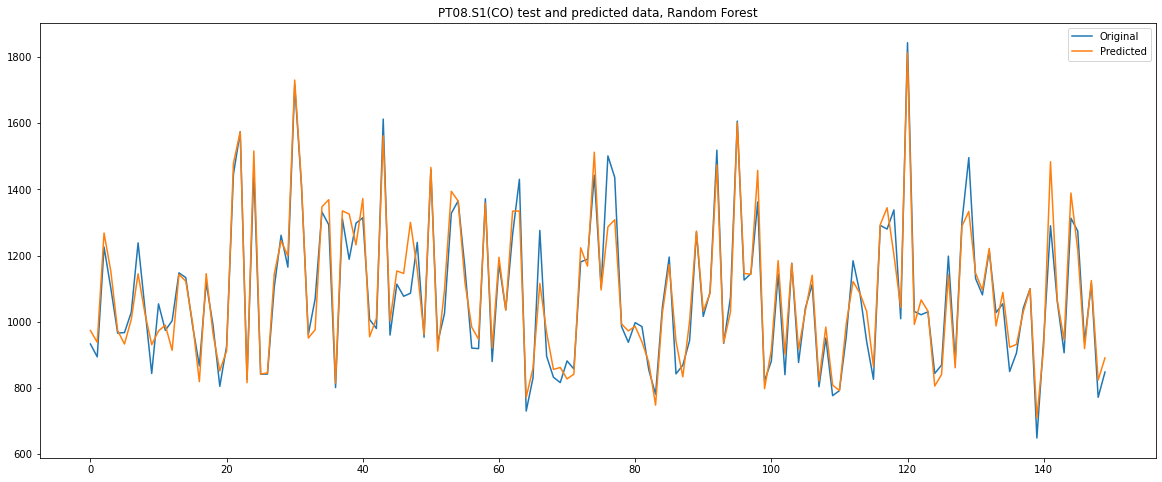

In [36]:
size_plt = 150 # size of the dataset to plot

plt.figure(figsize=(20,8))
x_ax = range(len(y_test[:size_plt]))
plt.plot(x_ax, y_test[:size_plt], label="Original")
plt.plot(x_ax, y_pred_rf[:size_plt], label="Predicted")
plt.title("PT08.S1(CO) test and predicted data, Random Forest")
plt.legend()
plt.show()

### Tuning parameters of a model
As XGBoost is quite powerful and offers some interesting options it will pass through a process of parameter tuning.<br><br>
Instead of using gridsearch, excellent but slow, it'll be used [Optuna]('https://optuna.org/'). Optuna turns out to be an agnostic and automatic parameter search. <br>
Some parameters, to be tuned, were chosen from the list of [parameters of XGBoost]('https://xgboost.readthedocs.io/en/latest/parameter.html') to plug in optuna.
<br><br>
Bellow the list of current parameters of the model used to fit the data.

In [37]:
# parameters of the current model
xgbr.get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': 0}

In [38]:
import optuna

In [39]:
# objective function to be used by optuna study
def objective(trial):
    
    x_max_depth = trial.suggest_int('max_depth', 3, 10)
    x_learning_rate = trial.suggest_uniform('learning_rate', 0.1, 1)
    x_gamma = trial.suggest_categorical('gamma', [0, 0.25, 0.5, 1.0])
    x_reg_lambda = trial.suggest_categorical('lambda', [0, 1, 5, 10, 20, 100])
    x_scale_pos_weight = trial.suggest_categorical('scale_pos_weight', [1, 3, 5])
    
    classifier_obj = xgb.XGBRegressor(verbosity=0, 
                                      max_depth=x_max_depth,
                                      learning_rate=x_learning_rate,
                                      gamma=x_gamma,
                                      reg_lambda=x_reg_lambda,
                                      scale_pos_weight=x_scale_pos_weight) 
    
    
    classifier_obj.fit(X_train, y_train)
    

    score = np.mean(cross_val_score(classifier_obj, X_train, y_train, cv=10))
    accuracy = score.mean()
    return accuracy

In [40]:
study = optuna.create_study(direction="maximize") # maximize the cross_val_score
study.optimize(objective, n_trials=100)
print(study.best_trial)

[I 2020-08-15 12:53:58,275] Trial 0 finished with value: 0.9290334224678685 and parameters: {'max_depth': 8, 'learning_rate': 0.48317873040234716, 'gamma': 0.25, 'lambda': 5, 'scale_pos_weight': 3}. Best is trial 0 with value: 0.9290334224678685.
[I 2020-08-15 12:54:00,813] Trial 1 finished with value: 0.8655268684920598 and parameters: {'max_depth': 8, 'learning_rate': 0.9609372609604065, 'gamma': 0.5, 'lambda': 0, 'scale_pos_weight': 3}. Best is trial 0 with value: 0.9290334224678685.
[I 2020-08-15 12:54:02,684] Trial 2 finished with value: 0.935040527938763 and parameters: {'max_depth': 7, 'learning_rate': 0.27800353707278513, 'gamma': 1.0, 'lambda': 5, 'scale_pos_weight': 5}. Best is trial 2 with value: 0.935040527938763.
[I 2020-08-15 12:54:03,573] Trial 3 finished with value: 0.9258337532249851 and parameters: {'max_depth': 3, 'learning_rate': 0.5350102174557636, 'gamma': 1.0, 'lambda': 10, 'scale_pos_weight': 1}. Best is trial 2 with value: 0.935040527938763.
[I 2020-08-15 12:54

[I 2020-08-15 12:56:20,447] Trial 66 finished with value: 0.9374016025589025 and parameters: {'max_depth': 8, 'learning_rate': 0.17215513443957797, 'gamma': 1.0, 'lambda': 5, 'scale_pos_weight': 5}. Best is trial 66 with value: 0.9374016025589025.
[I 2020-08-15 12:56:23,559] Trial 67 finished with value: 0.934367595541433 and parameters: {'max_depth': 8, 'learning_rate': 0.27528652161182715, 'gamma': 1.0, 'lambda': 20, 'scale_pos_weight': 5}. Best is trial 66 with value: 0.9374016025589025.
[I 2020-08-15 12:56:25,837] Trial 68 finished with value: 0.9370397582674406 and parameters: {'max_depth': 8, 'learning_rate': 0.20108368135996407, 'gamma': 1.0, 'lambda': 5, 'scale_pos_weight': 5}. Best is trial 66 with value: 0.9374016025589025.
[I 2020-08-15 12:56:29,200] Trial 69 finished with value: 0.9334976194082341 and parameters: {'max_depth': 9, 'learning_rate': 0.17806421229028996, 'gamma': 1.0, 'lambda': 0, 'scale_pos_weight': 5}. Best is trial 66 with value: 0.9374016025589025.
[I 2020-

FrozenTrial(number=98, value=0.939445164034359, datetime_start=datetime.datetime(2020, 8, 15, 12, 58, 1, 405100), datetime_complete=datetime.datetime(2020, 8, 15, 12, 58, 4, 532753), params={'max_depth': 10, 'learning_rate': 0.12532046934721006, 'gamma': 1.0, 'lambda': 1, 'scale_pos_weight': 3}, distributions={'max_depth': IntUniformDistribution(high=10, low=3, step=1), 'learning_rate': UniformDistribution(high=1, low=0.1), 'gamma': CategoricalDistribution(choices=(0, 0.25, 0.5, 1.0)), 'lambda': CategoricalDistribution(choices=(0, 1, 5, 10, 20, 100)), 'scale_pos_weight': CategoricalDistribution(choices=(1, 3, 5))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=98, state=TrialState.COMPLETE)


Optuna found better parameters for XGBoost by optimizing the cross validation score.<br> 
The same model of before will be tested with the new parameters found.

In [44]:
#XGBoost Regressor
xgbr_t = xgb.XGBRegressor(verbosity=0,
                       max_depth=10,
                       learning_rate=0.12532046934721006,
                       gamma=1.0,
                       lamda=1,
                       scale_pos_weight=3) 
xgbr_t.fit(X_train, y_train)


print("XGBoost Regressor")
print("-----------------")
print("R2 score (train set): {:.4f}".format(xgbr_t.score(X_train, y_train)))
print("R2 score (test set): {:.4f}".format(xgbr_t.score(X_test, y_test)))

# 10-fold cross validation
xgbr_cv = np.mean(cross_val_score(xgbr_t, X_train, y_train, cv=10))
print("Mean cross validation 10-fold accuracy: {:.4f}".format(xgbr_cv))

# mean squared error
y_pred_xgbr = xgbr_t.predict(X_test)
mse = mean_squared_error(y_test, y_pred_xgbr)
print("MSE: {:.4f}".format(mse))
print("RMSE: {:.4f}".format(np.sqrt(mse)))

XGBoost Regressor
-----------------
R2 score (train set): 0.9950
R2 score (test set): 0.9385
Mean cross validation 10-fold accuracy: 0.9394
MSE: 3041.4391
RMSE: 55.1492


The new parameters gave the xgboost model a better fit over the train and test datasets.<br><br>
XGBoost also has the advantage of a graph displaying the importance of each feature for the trained model.

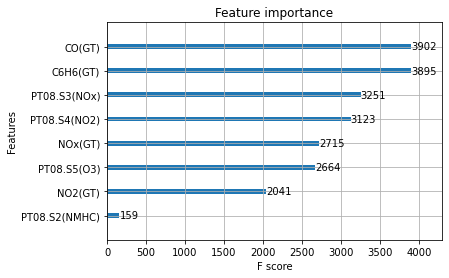

In [45]:
xgb.plot_importance(xgbr_t) 
plt.show()

Another feature of XGBoost is the that it makes it possible to print the tree representing the trained model.

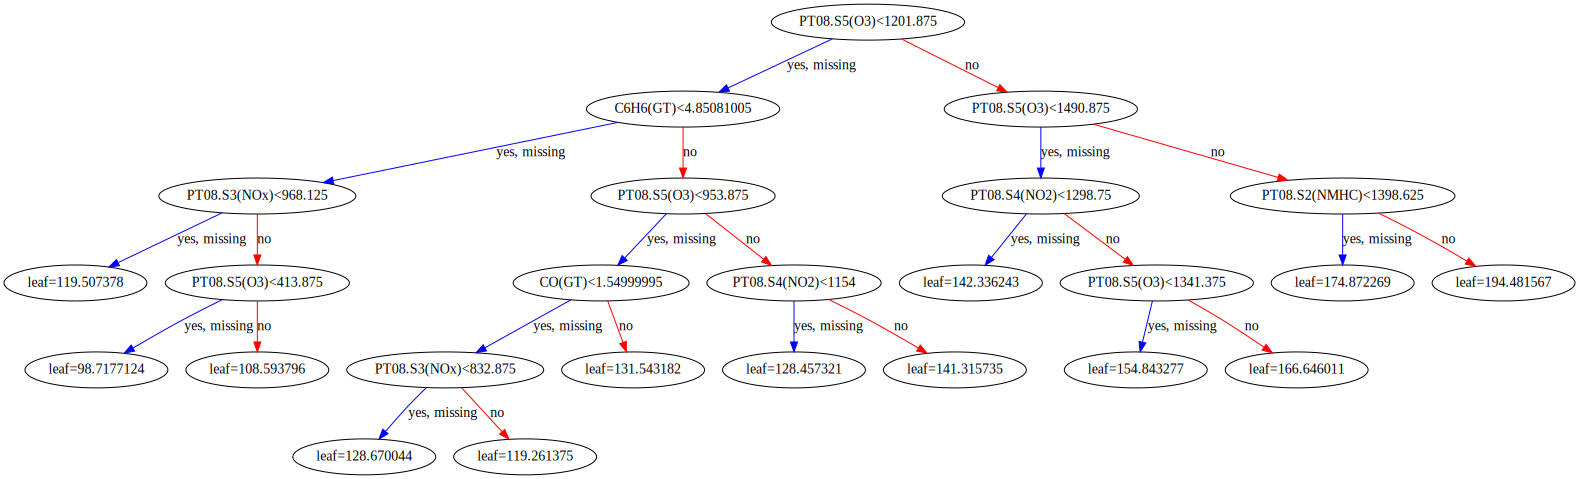

In [46]:
xgb.to_graphviz(xgbr_t, num_trees=0)